### Detecting permafrost in UKESM1 model output

The data used for this investigation was derived from a single UKESM1 run using its default low-resolution setup. The run followed the historical setup from 1850-2014 (Eyring et al., 2016), and branched at 2015 into different scenarios for the years 2015-2100 based on shared socioeconomic pathways (SSPs) and climate outcomes for 2100 driven by prescribed radiative forcings (O’Neill et al., 2016). For each scenario, UKESM1 output was analysed to identify the  the global area of permafrost using monthly surface air temperature (at 1.5 m) and soil temperature (at a depth of 2.0 m).

Permafrost areas were identified following the criteria of Slater and Lawrence (2013) as cells where the annual mean soil temperature at a depth of 2.0 m remained below 0°C for at least two consecutive years. Since this is likely to prove an underestimate of areas of discontinuous permafrost, the isotherm of mean annual surface temperature of 0°C and -4.3°C were also calculated, as these closely define areas where there is respectively >1% and >50% likelihood of finding permafrost (Chadburn et al., 2017). The surface area was calculated based on the cell areas, taking into account the percentage of the cell filled by land. Anomalies in mean annual surface temperatures and mean carbon content in soil and vegetation were calculated relative to a baseline period of 1850-1900 calculated from the historical simulation.


Things still to do 28/10/20:
- Mask out areas with permanent ice e.g. Greenland ice sheet (need land ice fraction for this?)
- Look at impact of soil moisture?

In [7]:
#load packages
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import scipy

In [2]:
#calculate area of land for each cell
areacell = xr.open_dataset('CM_data/areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc')
lndfrac = xr.open_dataset('CM_data/sftlf_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc')

acl = areacell['areacella'].values
lfr = lndfrac['sftlf'].values
lp = lfr/100
lndarea = np.multiply(acl,lp)

#set lat and lon
lat = areacell['lat']
lon = areacell['lon']

In [3]:
#functions to load data and get time slice for plotting

def load_data(info):
    '''function to load data for variable and scenario
    Arguments:
    =========
    info = array of str, ccontaining variable[0], letter[1], senario[2]'''
    path = f'CM_data/{info[0]}_{info[1]}mon_UKESM1-0-LL_{info[2]}_r1i1p1f2_gn_*.nc'
    data = xr.open_mfdataset(paths=path,combine='by_coords')
    return data

def tsl_tslice(info,startdate,enddate,depth):
    '''function to return mean soil temp at selected depth for a timeslice'''
    ds = load_data(info)
    ds1 = ds.sel(time=slice(startdate,enddate))
    ds2 = ds1['tsl']
    ds_tsl_2K = ds2.sel(depth = depth, method='nearest')
    ds_tsl2 = ds_tsl_2K-273.15
    ds_tsl2_mean = ds_tsl2.mean(dim='time')
    return ds_tsl2_mean

#load files
tsl_hist = tsl_tslice((['tsl','L','historical']),'1850-01-01','1900-12-16',2.0)
tsl_bl = tsl_tslice((['tsl','L','historical']),'1961-01-01','1990-12-16',2.0)
tsl_126 = tsl_tslice((['tsl','L','ssp126']),'2090-01-01','2100-12-16',2.0)
tsl_245 = tsl_tslice((['tsl','L','ssp245']),'2090-01-01','2100-12-16',2.0)
tsl_370 = tsl_tslice((['tsl','L','ssp370']),'2090-01-01','2100-12-16',2.0)
tsl_585 = tsl_tslice((['tsl','L','ssp585']),'2090-01-01','2100-12-16',2.0)

In [4]:
#mask for soil temp < 0

def tsl_mask(name):
    '''Generates mask of area where mean annual soil temp < 0 C i.e. pf present'''
    mask = name
    mask = xr.where(mask>=0,np.nan,mask)
    mask = xr.where(mask<0,1,mask)
    return mask

pfs_hist = tsl_mask(tsl_hist)
pfs_bl = tsl_mask(tsl_bl)
pfs_126 = tsl_mask(tsl_126)
pfs_245 = tsl_mask(tsl_245)
pfs_370 = tsl_mask(tsl_370)
pfs_585 = tsl_mask(tsl_585)

In [5]:
def sat_tslice(info,startdate,enddate):
    '''Returns mean of time slice for given filename'''
    ds = load_data(info)
    ds1 = ds.sel(time=slice(startdate,enddate))
    ds2 = ds1['tas']
    ds3 = ds2-273.15
    ds4 = ds3.mean(dim='time')
    return ds4

def sat_mask(info,startdate,enddate,temp):
    '''return a mask of areas where annual mean sat < temp (int in C)'''
    name = sat_tslice(info,startdate,enddate) 
    mask = name
    mask = xr.where(mask>temp,np.nan,mask)
    mask = xr.where(mask<=temp,1,mask)
    return mask
    
#define masks for the surface air temp <0 and <-4.3
pfa0_hist = sat_mask((['tas','A','historical']),'1850-01-01','1900-12-16',0)
pfa0_bl = sat_mask((['tas','A','historical']),'1961-01-01','1990-12-16',0)
pfa0_126 = sat_mask((['tas','A','ssp126']),'2090-01-01','2100-12-16',0)
pfa0_245 = sat_mask((['tas','A','ssp245']),'2090-01-01','2100-12-16',0)
pfa0_370 = sat_mask((['tas','A','ssp370']),'2090-01-01','2100-12-16',0)
pfa0_585 = sat_mask((['tas','A','ssp585']),'2090-01-01','2100-12-16',0)

pfa43_hist = sat_mask((['tas','A','historical']),'1850-01-01','1900-12-16',-4.3)
pfa43_bl = sat_mask((['tas','A','historical']),'1961-01-01','1990-12-16',-4.3)
pfa43_126 = sat_mask((['tas','A','ssp126']),'2090-01-01','2100-12-16',-4.3)
pfa43_245 = sat_mask((['tas','A','ssp245']),'2090-01-01','2100-12-16',-4.3)
pfa43_370 = sat_mask((['tas','A','ssp370']),'2090-01-01','2100-12-16',-4.3)
pfa43_585 = sat_mask((['tas','A','ssp585']),'2090-01-01','2100-12-16',-4.3)

In [11]:
#mask for ocean (needed for tas data)
def oceanmask(name):
    mask = name.fillna(100)
    mask = xr.where(mask<50,np.nan,mask)
    mask = mask.to_masked_array()
    return mask

ocean = oceanmask(tsl_hist)

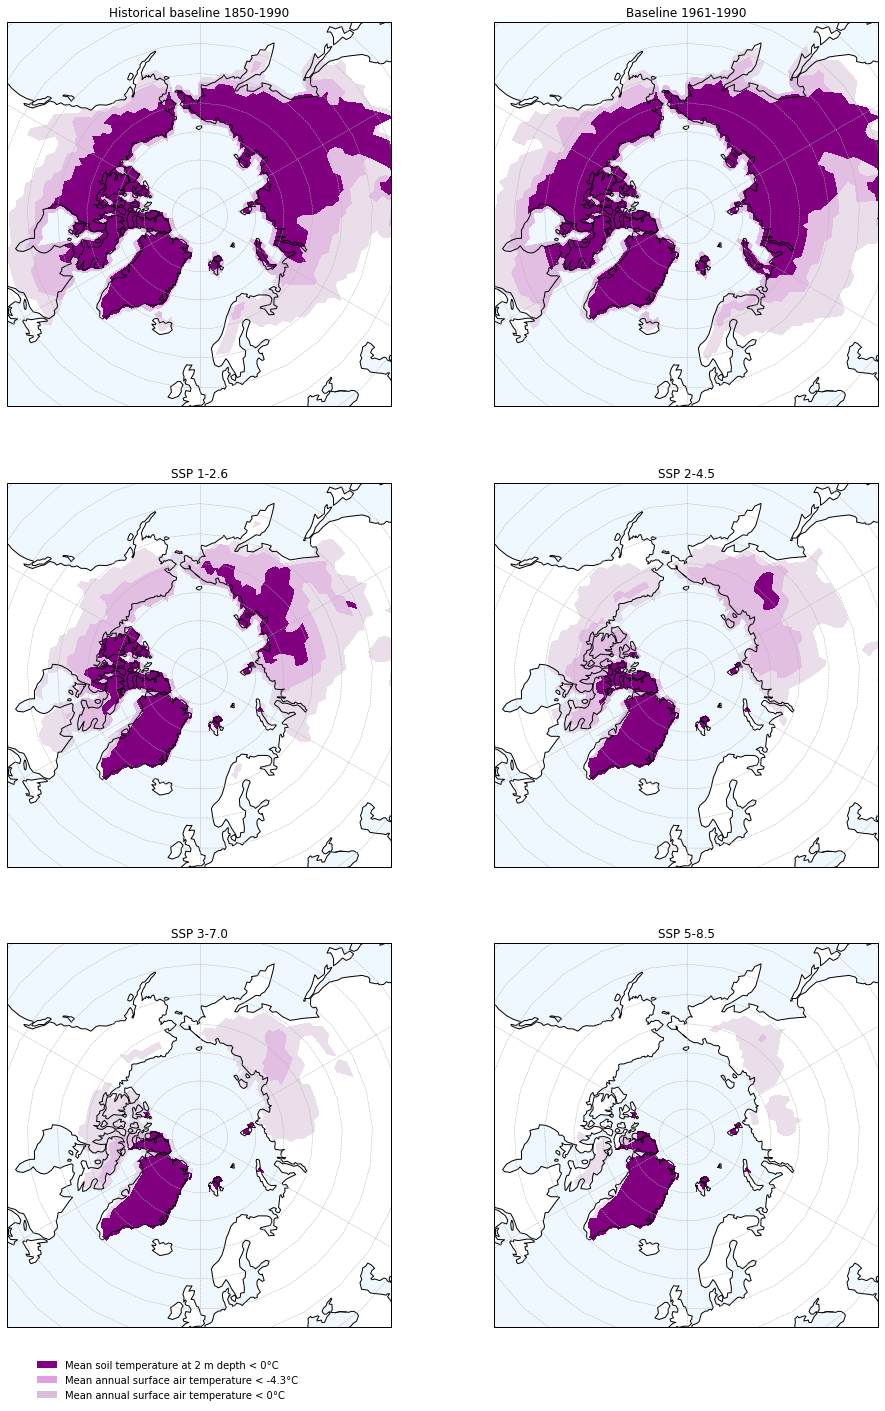

In [14]:
#test plot
#ditch all of those bloody dask warnings

import warnings
warnings.simplefilter("ignore") 

#define cartopy projections
projection=ccrs.NorthPolarStereo()
transform = ccrs.PlateCarree()

#set up figure
#sublot_kw hack from cartopy/mpl formum
fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(16,24),
                        subplot_kw=dict(projection=projection))
titles = ('Historical baseline 1850-1990','Baseline 1961-1990','SSP 1-2.6','SSP 2-4.5',
          'SSP 3-7.0','SSP 5-8.5')
pfs = (pfs_hist,pfs_bl,pfs_126,pfs_245,pfs_370,pfs_585)
pfa0 = (pfa0_hist,pfa0_bl,pfa0_126,pfa0_245,pfa0_370,pfa0_585)
pfa43 = (pfa43_hist,pfa43_bl,pfa43_126,pfa43_245,pfa43_370,pfa43_585)

#plot on subplot
for ax,ps,pa0,pa43,t in zip(axes.flat,pfs,pfa0,pfa43,titles):
    ax.set_title(t)
    ax.set_extent([-180,180,50,90],ccrs.PlateCarree())
    ax.gridlines(linewidth=0.5,linestyle='--')
    ax.coastlines()
    ax.add_feature(cartopy.feature.OCEAN,facecolor='aliceblue')
    ax.add_feature(cartopy.feature.LAND, facecolor='white')
    im = ax.contourf(lon,lat,pa0,transform=transform,colors='thistle',alpha=0.5)
    im = ax.contourf(lon,lat,pa43,transform=transform,colors='plum',alpha=0.5)
    im = ax.contourf(lon,lat,ps,transform=transform,colors='purple')
    im = ax.contourf(lon,lat,ocean,transform=transform, colors='aliceblue')

pfarea = patches.Rectangle((0, 0), 1, 1, facecolor="purple")
satarea1 = patches.Rectangle((0, 0), 1, 1, facecolor="plum")
satarea2 = patches.Rectangle((0, 0), 1, 1, facecolor="thistle")
labels = ['Mean soil temperature at 2 m depth < 0\u00B0C',
          'Mean annual surface air temperature < - 4.3\u00B0C',
          'Mean annual surface air temperature < 0\u00B0C']
plt.legend([pfarea, satarea1,satarea2], labels,loc='lower center', 
           bbox_to_anchor=(-1.2, -0.2, 1., .2),mode="expand", borderaxespad=0.,frameon=False)

In [26]:
#generate series of pf area (this needs work to get a better rolling mean)

def pf_series(dataset):
    years = np.unique(dataset['time.year'])   
    pf_series = np.zeros(years.shape)
    sz = range(len(years))
    
    for x,s in zip(years,sz):
        d = dataset.sel(time=slice(f'{x}-01-01',f'{x+1}-12-16'))
        d1 = d['tsl']
        d2 = d1.sel(depth=2.0,method='nearest')
        d3 = d2-273.15
        d4 = d3.mean(dim='time')
        
        mask = d4
        mask = xr.where(mask>=0,np.nan,mask)
        mask = xr.where(mask<0,1,mask)
        d5 = np.multiply(mask,lndarea)
        d6 = np.nansum(d5)
        pf_series[s]=d6/1000000
    
    return pf_series 

ps_hist = pf_series(load_data((['tsl','L','historical'])))
ps_126 = pf_series(load_data((['tsl','L','ssp126'])))
ps_245 = pf_series(load_data((['tsl','L','ssp245'])))
ps_370 = pf_series(load_data((['tsl','L','ssp370'])))
ps_585 = pf_series(load_data((['tsl','L','ssp585'])))

#calculate 1850-1900 mean

Text(0.5, 1.0, 'Permafrost area over time')

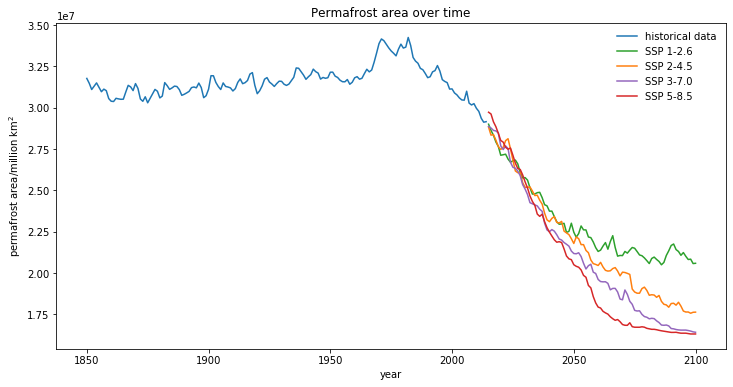

In [30]:
#plot permafrost area over time
x = range(1850,2015)
y = range(2015,2101)
fig = plt.figure(figsize=(12,6))
plt.plot(x,ps_hist,label='historical data')
plt.plot(y,ps_126,color='#2CA02C',label='SSP 1-2.6')
plt.plot(y,ps_245,color='#FF7F0E',label='SSP 2-4.5')
plt.plot(y,ps_370,color='#9467BD',label='SSP 3-7.0')
plt.plot(y,ps_585,color='#D62728',label='SSP 5-8.5')
plt.legend(loc='best',frameon=False)
plt.xlabel('year')
plt.ylabel('permafrost area/million km$^2$')
plt.title('Permafrost area over time')

### References

Chadburn, S. E. et al. (2017) An observation-based constraint on permafrost loss as a function of global warming. Nature Climate Change. [Online] 7 (5), 340–344.

Eyring, V. et al. (2016) Overview of the Coupled Model Intercomparison Project Phase 6 (CMIP6) experimental design and organization. Geoscientific Model Development. [Online] 9 (5), 1937–1958.

O’Neill, B. C. et al. (2016) The Scenario Model Intercomparison Project (ScenarioMIP) for CMIP6. Geoscientific Model Development. [Online] 9 (9), 3461–3482.

Slater, A. G. & Lawrence, D. M. (2013) Diagnosing Present and Future Permafrost from Climate Models. Journal of Climate. [Online] 26 (15), 5608–5623.